In [1]:
# Import pre-trained VGG19
# https://pytorch.org/hub/pytorch_vision_vgg/
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)

model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /home/mes3wv/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/mes3wv/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [2]:
# Helper function for finetuning in Pytorch
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [3]:
# Number of classes in the dataset
num_classes = 2
# Batch size for training, this will be used later in fine-tuning
batch_size = 8

# Number of epochs to train for this will be used later in fine-tuning
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = True


In [8]:
from torchvision import transforms
from torchvision import datasets



# Transform the data to be the correct size
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


# Define the training and validation directory paths
# Note this dataset came with three folders, test, train, and val
# I got rid of the val folder which only had like 9 images and renamed the test folder val
train_dir = '/home/mes3wv/chest_xray/train'
val_dir = '/home/mes3wv/chest_xray/val'


# Give it the filepath to find the data and perform the specified transformations
train_image_dataset =  datasets.ImageFolder(train_dir, transform=train_transforms)

test_image_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

# This is like the flow.from.directory in keras I think
train_dataloader = torch.utils.data.DataLoader(train_image_dataset, batch_size=64, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size=32)

# Specify the classes
classes = ('NORMAL', 'PNEUMONIA')


In [9]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 0 %


In [10]:
# This is a way of looking at a few images and just seeing what the class labels are for them to check if
# everything is working as expected
dataiter = iter(test_dataloader)
images, labels = dataiter.next()


print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:  NORMAL NORMAL NORMAL NORMAL


In [11]:
from torch import optim
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.16.weight
	 features.16.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.32.weight
	 features.32.bias
	 features.34.weight
	 features.34.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [12]:
import os
data_dir = '/home/mes3wv/chest_xray'
input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [14]:
import time
import copy
import torch.nn as nn

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.2465 Acc: 0.4750
val Loss: 0.7274 Acc: 0.5250

Epoch 1/9
----------
train Loss: 0.8701 Acc: 0.5250
val Loss: 0.9790 Acc: 0.5000

Epoch 2/9
----------
train Loss: 0.8123 Acc: 0.5800
val Loss: 0.5927 Acc: 0.8050

Epoch 3/9
----------
train Loss: 0.7369 Acc: 0.6800
val Loss: 0.6630 Acc: 0.6300

Epoch 4/9
----------
train Loss: 0.6313 Acc: 0.7150
val Loss: 0.4901 Acc: 0.8150

Epoch 5/9
----------
train Loss: 0.4538 Acc: 0.7750
val Loss: 0.4436 Acc: 0.8200

Epoch 6/9
----------
train Loss: 0.3945 Acc: 0.8400
val Loss: 0.5931 Acc: 0.7000

Epoch 7/9
----------
train Loss: 0.5583 Acc: 0.7800
val Loss: 0.5734 Acc: 0.7900

Epoch 8/9
----------
train Loss: 0.4943 Acc: 0.8000
val Loss: 0.6558 Acc: 0.6800

Epoch 9/9
----------
train Loss: 0.4329 Acc: 0.8550
val Loss: 0.4593 Acc: 0.8300

Training complete in 8m 16s
Best val Acc: 0.830000


In [21]:
import numpy as np
train_acc = np.array([ 0.4750,0.5250,0.5800,0.6800, 0.7150,0.7750,0.8400,0.7800, 0.8000,0.8550])

In [23]:
# Plot the accuracy of the classification of the Test set over 10 Epochs
import matplotlib.pyplot as plt
acc = train_acc
val_acc = [h.cpu().numpy() for h in hist]
#loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

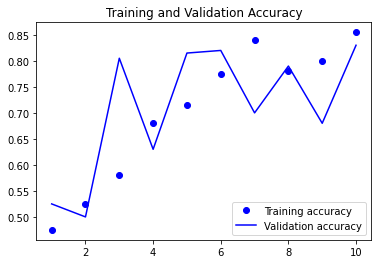

In [25]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()